#**Shrinkage Estimator of Mean of Symmetric Positive Definite (SPD) matrices**

Following notebook implements and explores the use of Shrinkage Estimator for Frechet Mean on manifold of Symmetric Positive Definite (SPD) matrices. Shrinkage Estimators are class of estimators that are better than Maximum Likelihood Estimators in terms of error. The Notebook is split into Four Section. In First Section,  We will see about classic James 
Stein Estimator for euclidean spaces and how it performs significantly better than MLE(empirical mean). In Next Section, we will see about shrinkage estimator on manifold of SPD matrices and see it improves upon on MLE on synthetic dataset. In third section , we will see about novel type of application in Human Action Reconginition. In last section we will see about some of limitations of method. 

### Table of Contents

* [1. Illustration of Shrinkage Estimator in $\mathbb{R}^n$](#chapter1)
    * [1.1 Implementation of Estimator](#section_1_1)
    * [1.2 Analysis on Big Data vs Low Data Regime](#Section_1_2)
* [2. Illustration of Shrinkage Estimator in $\text{Sym}_{n}^+$](#chapter1)  
    * [1.1 Implementation of Estimator](#section_1_2_1)
    * [1.2 Profiling the Code](#Section_1_2)  
    * [1.3 Ablation Study](#Section_1_3)
    * [1.4 Would-be-nice to have features in Geomstats](#Section_1_4)

* [3. Applications ](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)

* [4. References ](#chapter2)






In [ ]:
!pip3 install geomstats

In [ ]:
import numpy as np
import geomstats.geometry.spd_matrices as spd
import geomstats.backend as gs
from sklearn.metrics import mean_squared_error
from scipy.stats import invwishart
import scipy.optimize as optimize
from tqdm.notebook import tqdm

##**Illustration of James Stein Estimator in $\mathbb{R}^n$**

James and Stein showed that there exists class of estimators that  have less quadratic error than Maximum Likelihood Estimator (MLE) for mean of Normal distribution. Specifically assuming $X_i \sim \mathcal{N}(\mu_i , \sigma^2)$ and assuming $\sigma^2$ is known the estimator

$$X_{\text{js}} = \left( 1- \frac{(d-2)\sigma^2}{N\overline{X}} \right)\overline{X} , \text{ where } \overline{X} = \frac{1}{N} \sum_{i=1}^N X_i$$

dominates $X_{\text{mle}} =  \frac{1}{N} \sum_{i=1}^N X_i $, when $d \geq 3$. Note that  assumption $\sigma^2$ is known can be relaxed. By using substituting $\sigma^2$ with $\text{mle}$, one does get similar result.

In [ ]:


def generate_data(N,d):
  """
  N : number of data points
  m : dimension of each data point
  """
 
  means = np.full((d), 0)
  sigmas = np.full((d),1)
  data = np.random.normal(means,sigmas,(N,d))
  return data,means,sigmas


In [ ]:
def mle_and_jse(data):
  """
    data : numpy array
    Returns
    mle : Maximum Likeilhood Estimator
    jse : James Stein Estimator
  """

  mle = data.mean(axis = 0)
  N = data.shape[0]
  d = data.shape[1]
  jse_coeff = (1-(d-2)/(N*np.linalg.norm(mle)**2))
  jse = jse_coeff * mle
  return mle,jse

In [ ]:
def get_rmse(data,mean,sigma):
  
  mle,jse = mle_and_jse(data)
  mle_rmse = mean_squared_error(mle,mean,squared=False)
  jse_rmse = mean_squared_error(jse,mean,squared=False)
  return mle_rmse,jse_rmse

In [ ]:
N = 10000
d = 10000
data,mean,sigma = generate_data(N,d)
mle_rmse, jse_rmse =  get_rmse(data,mean,sigma)
print("RMSE for Maximum Likelihood Estimator" , mle_rmse)
print("RMSE for James Stein Estimator" , jse_rmse)


RMSE for Maximum Likelihood Estimator 0.00999680007015171
RMSE for James Stein Estimator 4.400243788623158e-06


Analysis of Big-data and Low-data regime

In [ ]:
def analysis(Ns,ds):
  
  scores = np.zeros((len(ds),len(Ns)))
  for i,d in tqdm(enumerate(ds)):
    for j,N in tqdm(enumerate(Ns)):
      data,mean,sigma = generate_data(N,d)
      mle,jse = mle_and_jse(data)
      mle_rmse = mean_squared_error(mle,mean,squared=False)
      jse_rmse = mean_squared_error(jse,mean,squared=False)
      scores[i,j] = mle_rmse/jse_rmse

  return scores
  


In [ ]:
# Ns = np.arange(10,50000*2,400)
# print(len(Ns))
# ds = [1000,100,10,5]
# scores = analysis(Ns,ds)

250


Following plots show that Improvement of James Stein Estimator over Number of Data points by dimension and number of data points.

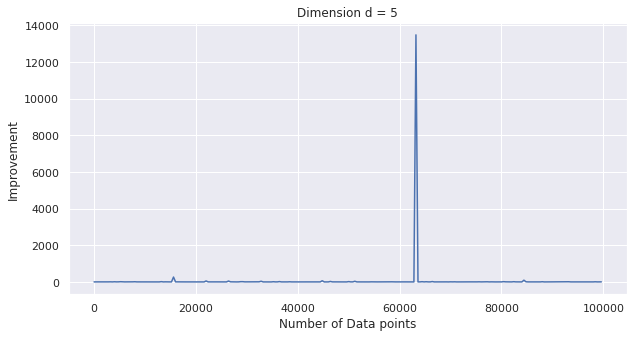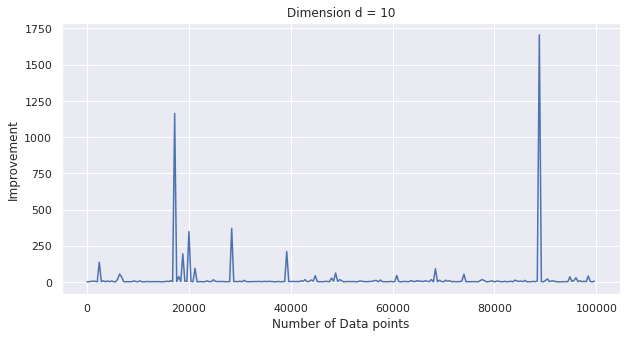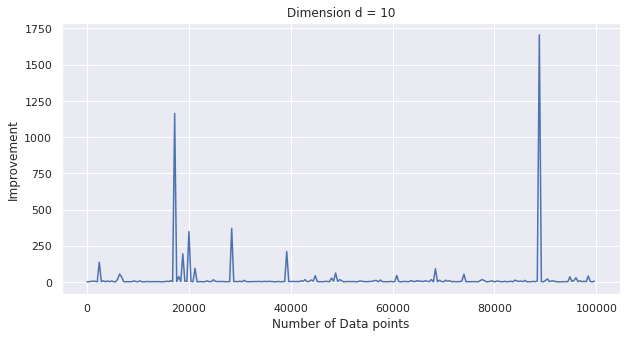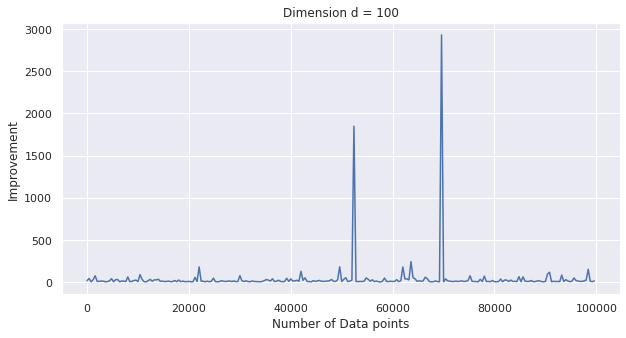

In [ ]:
def logm(spd_mats):
  """
  could be two_dim,three_dim,four_dim
  spd_matrix : [n,n] , [p,n,n] , [p,N,n,n]

  Returns:
  ------------
  return logm_m
  """

  n = spd_mats.shape[-1]
  SPDmanifold = spd.SPDMatrices(n)
  if spd_mats.ndim == 2 or spd_mats.ndim == 3 :
    log_m = SPDmanifold.logm(spd_mats)
  elif spd_mats.ndim == 4:
    p,N = spd_mats.shape[0] , spd_mats.shape[1]
    log_m = (SPDmanifold.logm(spd_mats.reshape(-1,n,n))).reshape(p,N,n,n) 
  else :
    print("error exception!!!")  
    log_m = None
  
  return log_m

In [ ]:
def expm(spd_mats):
  """
  could be two_dim,three_dim,four_dim
  spd_matrix : [n,n] , [p,n,n] , [p,N,n,n]

  Returns:
  ------------
  return exp_m
  """

  n = spd_mats.shape[-1]
  SPDmanifold = spd.SPDMatrices(n)
  if spd_mats.ndim == 2 or spd_mats.ndim == 3 :
    exp_m = SPDmanifold.expm(spd_mats)
  elif spd_mats.ndim == 4:
    p,N = spd_mats.shape[0] , spd_mats.shape[1]
    exp_m = (SPDmanifold.expm(spd_mats.reshape(-1,n,n))).reshape(p,N,n,n) 
  else :
    print("error exception!!!")  
    exp_m = None
  
  return exp_m

In [ ]:
#isometric embedding of SPD(n) matrix in R^{n(n+1)/2}

def SPD_to_Euclidean(spd_matrix):
  """
    spd_matrix : Symmetric positive definite matrix

    Returns: numpy array of dimension (n(n+1)/2,)
    Isometric Embedding of n x n Symmetric positive definite matrix in R^{n(n+1)/2} 
  """ 
  n = spd_matrix.shape[0]
  sym_matrix = logm(spd_matrix)
  diag = np.diag(sym_matrix)
  uppTri = np.sqrt(2)*sym_matrix[np.triu_indices_from(sym_matrix, k=1)]
  vecd =  np.hstack((diag,uppTri))
  return vecd


In [ ]:
def batch_SPD_to_Euclidean(spd_mats):
  """
    spd_mats : [N,n,n]
  """
  pass
  # N,n = spt_mats.shape[0],spd_mats.shape[1]
  # SPDmanifold = spd.SPDMatrices(n)
  # sym_matrix = SPDmanifold.logm(spd_mats)



In [ ]:
#isometric embedding of R^{n(n+1)/2} matrix in SPD(n)

def Euclidean_to_SPD(euclidean_vec):
  """
    eucliden_vec : Euclidean column vector

    Returns: [n,n]
    Isometric Embedding of R^{n(n+1)/2} into n x n symmetric definite matrix
  """
  q = euclidean_vec.shape[0]
  n = (int)((- 1 + np.sqrt(1+8*q))/2)
  diag = euclidean_vec[:n]
  off_diag = euclidean_vec[n:]/(np.sqrt(2))
  sym_matrix = np.diag(diag)
  i,j = np.triu_indices_from(sym_matrix, k=1)
  sym_matrix[i,j] = off_diag
  sym_matrix[j,i] = off_diag
  spd_matrix = expm(sym_matrix)
  return spd_matrix


In [ ]:
#samples SPD matrices according to log-normal distribution with mean 'mean' and covariance 'cov'

def log_normal_sampling(mean,cov,sample_size=1):
  """
    mean : SPD matrix n x n
    cov  : SPD matrix n(n+1)/2 x n(n+1)/2 

    Returns:
    list of SPD matrices of size 'sample_size' 

    TODO
    vectorize conversion part
  """
 
  mean_euclidean = SPD_to_Euclidean(mean)
  samples_spd = []
  manifold = spd.SPDMatrices(mean.shape[0])
  samples_euclidean = np.random.multivariate_normal(mean_euclidean, cov, sample_size)
  for i in range(sample_size):
    sample_spd = Euclidean_to_SPD(samples_euclidean[i])
    samples_spd.append(sample_spd)
    
  samples_spd = np.array(samples_spd) 
  return samples_spd if (gs.all(manifold.belongs(samples_spd))) else None

In [ ]:
# testing the embeddings between SPD and euclidean

mat = 4*np.array([[2,-1,0],[-1,2,-1],[0,-1,2]])
euclidean = SPD_to_Euclidean(mat) 
spd_mat = Euclidean_to_SPD(euclidean)
print("Original matrix\n" , mat)
print("Euclidean Embedding of the Matrix\n", euclidean.shape)
print("Back to SPD space\n" , spd_mat)

Original matrix
 [[ 8 -4  0]
 [-4  8 -4]
 [ 0 -4  8]]
Euclidean Embedding of the Matrix
 (6,)
Back to SPD space
 [[ 8.00000000e+00 -4.00000000e+00  7.73346434e-15]
 [-4.00000000e+00  8.00000000e+00 -4.00000000e+00]
 [ 7.60339362e-15 -4.00000000e+00  8.00000000e+00]]


In [ ]:
#sampling from log_normal distribution
sample_size = 5*2000
mean = 4*np.array([[2,-1,0],[-1,2,-1],[0,-1,2]])
q    = (int)((mean.shape[0] * (mean.shape[0] + 1))/2)
cov  = np.eye(q)
samples = log_normal_sampling(mean,cov,sample_size)
print(samples.shape)
if samples is not None :
  print(samples)
else:
  print("some error has occured!")  


(10000, 3, 3)
[[[ 10.61735335  -6.84855571   5.30018162]
  [ -6.84855571   6.51590229  -2.5489763 ]
  [  5.30018162  -2.5489763    5.15900141]]

 [[ 47.80950929 -23.40231478  11.40613149]
  [-23.40231478  13.23952313  -6.05207134]
  [ 11.40613149  -6.05207134  11.69396571]]

 [[ 64.3004915  -19.93787733   7.97671196]
  [-19.93787733   7.69232758  -4.68899449]
  [  7.97671196  -4.68899449  21.93997049]]

 ...

 [[ 23.57104515 -22.75876417  11.31875558]
  [-22.75876417  31.14670438 -22.94680427]
  [ 11.31875558 -22.94680427  23.95440948]]

 [[ 37.13858667 -34.72193611  46.79634467]
  [-34.72193611  34.06066357 -45.08801395]
  [ 46.79634467 -45.08801395  63.61577751]]

 [[ 28.63234238 -21.02441768 -13.72937451]
  [-21.02441768  27.53687486  12.83519293]
  [-13.72937451  12.83519293  10.72399471]]]


In [ ]:
#given N SPD matrices, computes frechet mean using Log Euclidean Metric using closed form

def frechet_mean_LE(spd_matrices):
  """
  Parameters:
  ------------
  spd_matrices : array of spd_matrices

  Returns
  ------------
  mean  : array
  """
  n = spd_matrices.shape[1]
  log_samples = logm(spd_matrices)
  log_mean = log_samples.mean(axis=0)
  mean = expm(log_mean)
  return mean




In [ ]:
def batch_frechet_mean_LE(spd_mats):
  """
    spd_mats : [p,N,n,n]
    
    Returns
    ---------
    fms : frechet means shape [p,n,n]
  """

  p,N,n = spd_mats.shape[0],spd_mats.shape[1],spd_mats.shape[2]
  logs  = logm(spd_mats)
  mean  = logs.mean(axis=1)  #[p,n,n]
  fms   = expm(mean)    #[p,n,n]
  return fms

In [ ]:
def emp_cov(spd_matrices):
  """
    spd_matrices : array of spd_matrices
    Returns: [N,n,n]
    --------
    Emperical Covariance of euclidean embeddings of spd_matrices
  """

  N = spd_matrices.shape[0]
  euclidean_embeddings = [] 
  fm = frechet_mean_LE(spd_matrices)
  euclidean_fm = SPD_to_Euclidean(fm)
  for spd_mat in spd_matrices:
    euclidean_embedding = SPD_to_Euclidean(spd_mat)
    euclidean_embeddings.append(euclidean_embedding)

  euclidean_embeddings = np.array(euclidean_embeddings)  #(N,m)
  centered_embeddings  = euclidean_embeddings-euclidean_fm #(N,)
  emp_cov = np.einsum('ij,ik->jk',centered_embeddings,centered_embeddings)
  normalized_cov = emp_cov/N

  manifold = spd.SPDMatrices(emp_cov.shape[0])
  return normalized_cov if gs.all(manifold.belongs(emp_cov)) else None

In [ ]:
fm = batch_frechet_mean_LE(samples[None])
print(fm)

[[[ 8.0723786  -4.13250621 -0.05095252]
  [-4.13250621  8.2071903  -4.05412579]
  [-0.05095252 -4.05412579  8.12699348]]]


In [ ]:
fm = frechet_mean_LE(samples)
print(fm)

[[ 8.0723786  -4.13250621 -0.05095252]
 [-4.13250621  8.2071903  -4.05412579]
 [-0.05095252 -4.05412579  8.12699348]]


Generative Model:

$\Sigma_i \sim \text{Inv-Wishart}(\Psi,\nu) \,\,i = 1,\dots,p$ 

$M_{i}|\Sigma_i \sim \text{LN}(\boldsymbol{\mu},\lambda^{-1}\Sigma_i) , i=1,\dots,p$

$X_{ij}|(\text{M}_{i},\Sigma_i) \sim \text{LN}(\text{M}_{i} , \Sigma_i) , i=1,\dots,p  \text{ and } j=1,\dots,n$


where $\Psi ,\boldsymbol{\mu},M_{i},X_{ij}\in P_{N} $ and $ \nu > N-1$ and $\lambda>0$ 

In [ ]:
ec = emp_cov(samples)
if ec is not None:
  print(ec.shape)
  print(ec)
else :
  print("Not Positive Definite! Error")  

(6, 6)
[[ 1.00969489e+00 -1.64540478e-02  8.56520583e-04 -5.78645694e-03
   1.34100294e-02  4.96436284e-03]
 [-1.64540478e-02  1.01736144e+00  7.71105676e-03  7.72131953e-03
  -2.83596934e-03  1.70607003e-02]
 [ 8.56520583e-04  7.71105676e-03  9.81065311e-01  6.91907426e-03
  -2.36388233e-02 -8.74618949e-03]
 [-5.78645694e-03  7.72131953e-03  6.91907426e-03  9.95143776e-01
  -1.70689166e-03  7.66627804e-03]
 [ 1.34100294e-02 -2.83596934e-03 -2.36388233e-02 -1.70689166e-03
   1.01010976e+00 -1.33832841e-04]
 [ 4.96436284e-03  1.70607003e-02 -8.74618949e-03  7.66627804e-03
  -1.33832841e-04  9.91253380e-01]]


In [ ]:
def check_constraints(mu,psi,p,N,nu,L):
  """
  checks if constraints are satisfied before sampling
  """
  return True


In [ ]:
def Synthetic_Data(mu,psi,nu,L,p,N):
  """
    mu: PSD matrix (n,n) psi : PSD matrix (n*(n+1))/2 x (n*(n+1))/2
    p: real number , N : real number , nu: real number

    Returns
    --------
    X : numpy array shape : (p,N,n,n)
  """

  if not check_constraints(mu,psi,p,N,nu,L): 
    print("Parameters are not valid! Error!")
    return None

  #generate covariance matrix required
  sigmas = invwishart.rvs(df=nu,scale=psi,size=p)
  if sigmas.ndim == 2:
    sigmas = sigmas[None]

  scaled_sigmas = sigmas/L
  Ms = []
  for i in range(p):
    M_i = log_normal_sampling(mu,scaled_sigmas[i],sample_size=1)
    Ms.append(M_i)
  Ms = np.vstack(Ms) 
  X = []
  for i in range(p):
    X_i = log_normal_sampling(Ms[i],sigmas[i],sample_size=N)
    X.append(X_i)
  X = np.array(X) #[p,N,n,n]
  return X,Ms


In [ ]:
def LE_error(est,true):
  """
  est  : [p,n,n]
  true : [p,n,n]
  """

  diff  = logm(est) - logm(true)
  mean_error = np.trace(np.matmul(diff,diff),axis1=1,axis2=2).mean()
  return mean_error

In [ ]:
def get_MLE_Error(data,true):
  """
  data : [p,N,n,n]
  """
  n = data.shape[2]
  fms = batch_frechet_mean_LE(data) #[p,n,n]
  return LE_error(fms,true)

In [ ]:
mu = np.eye(3)
psi = np.eye(6)
nu = 15
L = 50
p = 100
N = 7

data,Ms = Synthetic_Data(mu,psi,nu,L,p,N)
print("Means shape",Ms.shape)
print("Data shape",data.shape)  
FM_MLE = get_MLE_Error(data,Ms)
print("FM LE", FM_MLE)

Means shape (100, 3, 3)
Data shape (100, 7, 3, 3)
FM LE 0.09079975674653343


In [ ]:
def sum_dist(X,mu):
  """
  X : (p,n,n)
  mu : (n,n)
  """
  p,n= X.shape[0],X.shape[1]
  SPDmanifold = spd.SPDMatrices(n)
  log_X  = SPDmanifold.logm(X)
  log_mu  = SPDmanifold.logm(mu)
  diff    = log_X - log_mu[None]
  sum_LE = np.trace(np.matmul(diff,diff),axis1=1,axis2=2).sum()
  print(sum_LE)
  return sum_LE

In [ ]:
def intialization(data,covs):
  """
  data : [p,N,n,n]
  covs : [p,n,n]
  Returns:
  --------
  x : numpy array with all parameters in single vector
  """

  #useful_terms 
  p,N,n = data.shape[0],data.shape[1],data.shape[2]
  q = (n*(n+1))/2
  sum_cov = covs.sum(axis=0) #[n,n]


  #mu_0 is frecht mean of frechet means
  fms = batch_frechet_mean_LE(data) #[p,n,n]
  mu_0 = frechet_mean_LE(fms)  #[n,n]


  #L_0 
  num_coeff = N/p
  _sum_dist = sum_dist(fms,mu_0)
  print(_sum_dist)
  num = num_coeff * _sum_dist
  term1 = (N/((N-1)*(p))) * np.trace(covs, axis1=1, axis2=2).sum()
  term2 =   _sum_dist/p
  denom = term1 - term2
  L_0 = num/denom
  

  #nu_0
  sum_inv_cov = np.linalg.inv(covs).sum(axis=0)
  trace_terms = np.einsum("ij,ji", sum_cov, sum_inv_cov) # tr(A,B)
  trace_coeff = (N-q-2)/(p**2 * q * (N-1))
  num = q+1
  denom = (trace_terms)*(trace_coeff) - 1
  term1 = num/denom
  term2 = q+1
  nu_0 = term1 + term2


  #psi_0
  coeff = (nu_0-q-1)/(p*(N-1))
  psi_0 = coeff * sum_cov

  theta = np.hstack((  L_0 , psi_0.ravel(), nu_0 , mu_0.ravel()  ) )

  # print("mean" , mu_0)
  # print("L_0" , L_0)
  # print("nu_0" , nu_0)
  # print("psi_0", psi_0)
  #print("theta" , theta)
  return theta


 **parameters of optimization**

$\lambda : $ scalar $\hspace{2.8cm}$ constraint : $\lambda >0$ $\hspace{1.9cm}$ $\lambda = x[:1]$

$\Psi : \frac{n(n+1)}{2} \times \frac{n(n+1)}{2}  \hspace{0.6cm} $ constraint : SPD matrix $\hspace{1cm}$ $\Psi = x[1:q]$

$\nu : $ scalar  $\hspace{2.8cm}$ constriant $ :\nu \geq q$ $\hspace{1.9cm}$ $\nu = x[q+1:q+2]$

$\mu : n \times n \hspace{2.8cm}$  constraint : SPD matrix $\hspace{1cm}$ $\mu = x[q+2:]$


**parameter vector x**

number of parameters $ = \frac{8+4n^2+n^2(n+1)^2}{4}$




In [ ]:
def theta_to_normal(theta,q,n):
  """
  theta : np array
  q     : scalar
  n     : scalar
  Returns:
  ------------
  L
  psi
  nu
  mu
  """
  
  q_s = (int)(q**2)
  L = theta[:1]
  psi = theta[1:q_s+1].reshape(q,q)
  nu = theta[q_s+1:q_s+2]
  mu = theta[q_s+2:].reshape(n,n)

  return L,psi,nu,mu




In [ ]:
def SURE(theta,fms,covs,N):
  """
    theta optimization parameter
    fms: \bar{X_i} i [p,n,n]
    covs: S_i [p,q,q]
    N: real
    ----------------
    Returns
    loss scalar

  """
  n   = fms.shape[1]
  p,q = covs.shape[0] , covs.shape[1]
  q_s = (int)(q**2)
  L,psi,nu,mu = theta_to_normal(theta,q,n)

  #constants 
  term_1 = (L+N)**-2
  term_2 = (N- (L**2)/N)/(N-1)
  term_3 = (nu + N - q - 2)**-2
  term_4 = (N-3 + (nu-q-1)**2)/((N+1)*(N-2))
  term_5 = ((N-1)**2 - (nu- q -1)**2)/((N+1)*(N-2)*(N-1))
  term_6 = -2 * (nu-q-1)/(N-1)

  #trace  
  trace_1 = np.trace(covs, axis1=1, axis2=2) #[p,]
  trace_2 = np.trace(np.matmul(covs,covs), axis1=1, axis2=2) #[p,]
  trace_3 = trace_1 ** 2 #[p,]
  trace_4 = np.trace(np.matmul(psi,covs), axis1=1, axis2=2) #[p,]
  trace_5 = np.einsum("ij,ji", psi, psi) #[1,]


  #dist
  log_X       = logm(fms)
  log_mu      = logm(mu)
  sum_LE      = np.sum((log_X-log_mu[None])**2 , axis=(1,2)) #[p,]

  #total loss
  loss_1  = term_1*(term_2 * trace_1 + L**2 * sum_LE) #[p,]
  loss_21 = term_4*trace_2 + term_5 * trace_3
  loss_22 = term_6*trace_4 + trace_5
  loss_2  = term_3*(loss_21+loss_22)
  loss    = (loss_1+loss_2).mean()
  #print("loss" , loss)
  # print("L" , L)
  # print("nu" , nu)
  return loss




In [ ]:
def get_bounds(q,n):
  q_s = (int)(q**2)
  n_s = (int)(n**2)
  bounds = [(1e-3,None)]
  for i in range(q_s):
    bounds.append((None,None))
  bounds.append((q,None))
  for i in range(n_s):
    bounds.append((None,None))
  print(len(bounds))
  return tuple(bounds)  

In [ ]:
def fit_shrinkage_estimator(data):
  """
    data:numpy array

    Returns :
    -----------
  """
  p,N,n = data.shape[0] , data.shape[1] , data.shape[2]
  fms = batch_frechet_mean_LE(data)
  covs = []
  for i in range(data.shape[0]):
    if emp_cov(data[i]) is not None:
      covs.append(emp_cov(data[i]))
    else:
      print("not working") 
  covs = np.array(covs)  
  q = covs.shape[1]
  print(covs.shape)
  theta  = intialization(data,covs)
  bounds = get_bounds(q,n) 
  res    = optimize.minimize(SURE, theta, args=(fms,covs,N),bounds=bounds, method='L-BFGS-B')
  if res.success is True :

    print("converged......")
    print("computing shrinkage estimator....")
    theta        = res.x
    L,psi,nu,mu = theta_to_normal(theta,q,n)
    log_X       = logm(fms)
    log_mu      = logm(mu)
    temp        = ((N * log_X) + (L * log_mu[None]))/(N+L)
    M           = expm(temp)

    num   = psi[None] + covs
    denom = nu+N-q-2
    sigmas = num/denom
    return M,sigmas

  else :
    print("ERROR! didn't converge") 
    return None,None

In [ ]:
def get_MLE(data):
   fms = batch_frechet_mean_LE(data)
   return fms


In [ ]:
MLE_M = get_MLE(data)

In [ ]:
shrink_M,shrink_sigmas = fit_shrinkage_estimator(data)
SPDmanifold = spd.SPDMatrices(shrink_M.shape[1])
print(SPDmanifold.belongs(shrink_M))

(100, 6, 6)
9.946909156883814
9.946909156883814
47
converged......
computing shrinkage estimator....
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [ ]:
print("distance between true and shrinkage" ,LE_error(shrink_M,Ms))
print("distance between true and fms" , LE_error(MLE_M,Ms))

distance between true and shrinkage 0.0656399280473841
distance between true and fms 0.09079975674653343


Now we will see Riemannian MDM

### **References**

(1) [W. James and C. M. Stein, “Estimation with Quadratic Loss,” in Proc.
Fourth Berkeley Symp. Math. Stat. Probab., pp. 361–380, 1961. ](http://www.stat.yale.edu/~hz68/619/Stein-1961.pdf) 

(2) [Efron, B. & Morris, C. (1973b), ‘Stein’s estimation rule and its competitors: An empirical
Bayes approach’, Journal of the American Statistical Association 68(341), 117–130](https://www.jstor.org/stable/2284155?seq=1) 

(3) [Schwartzman, A. (2016), ‘Lognormal distributions and geometric averages of symmetric
positive definite matrices’](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5222531/#:~:text=Analogously%2C%20a%20random%20symmetric%20positive,%2Dmatrix%2Dvariate%20lognormal%20distribution.)

(4) [Yang, Chun-Hao, Hani Doss, and B.C. Vemuri.(2020),An Empirical Bayes Approach to Shrinkage
Estimation on the Manifold of Symmetric
Positive-Definite Matrices ](https://arxiv.org/pdf/2007.02153.pdf)